In [26]:
import json
import math
import os
import requests
import scipy
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime as dt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import concatenate
from keras import metrics
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Read Tiles Dataset**

In [27]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles_expanded_balanced.csv')

In [28]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Collisions_Future,Collisions_Historical,Collision_binary_historical,Collision_binary_future
0,1373,1373,37.719094,37.719998,-122.389033,-122.390173,37.719546,-122.389603,8.0,2.0,2.0,1.0,1.0,1,1
1,2411,2411,37.726323,37.727227,-122.401575,-122.402715,37.726775,-122.402145,1.0,0.0,0.0,0.0,1.0,1,0
2,9047,9047,37.776925,37.777829,-122.409555,-122.410695,37.777377,-122.410125,0.0,0.0,0.0,1.0,1.0,1,1
3,8903,8903,37.775118,37.776021,-122.499624,-122.500765,37.775570,-122.500195,4.0,2.0,0.0,0.0,1.0,1,0
4,10938,10938,37.793190,37.794094,-122.435778,-122.436918,37.793642,-122.436348,4.0,1.0,0.0,0.0,1.0,1,0


In [29]:
tiles = tiles.rename(columns={'Collision_binary_future': 'label'})

In [30]:
tiles.columns

Index(['Unnamed: 0', 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat',
       'Mid_long', 'Stop_Signs', 'Bus_stop', 'Paving', 'Collisions_Future',
       'Collisions_Historical', 'Collision_binary_historical', 'label'],
      dtype='object')

In [31]:
# x: 'Tile_ID', 'Mid_lat', 'Mid_long',
#    'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
#    'Collision_binary_historical'
# y: 'Collision_binary_future'

X = tiles[['Tile_ID', 'Mid_lat', 'Mid_long', 'Stop_Signs', 'Bus_stop', 'Paving', 
           'Collisions_Historical', 'Collision_binary_historical']]
y = tiles[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

**RANDOM FOREST**

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [32]:
#def build_model():
#    model = Sequential()
#    model.add(Dense(20, input_dim=8, activation='relu'))
#    model.add(Dense(40, activation='relu'))
#    model.add(Dense(1, activation='sigmoid'))
#    # Compile model
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

#from keras.wrappers.scikit_learn import KerasClassifier
#keras_model = build_model()
#keras_model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1)

In [33]:
#y_pred_keras = keras_model.predict(X_test).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [34]:
#auc_keras = auc(fpr_keras, tpr_keras)

In [35]:
from sklearn.metrics import accuracy_score
# Supervised transformation based on random forests
rf = RandomForestClassifier(criterion="gini", max_depth=8, n_estimators=30)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

<ipython-input-35-4cb46dc52041>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#print(accuracy_score(y_test, y_pred_RF))

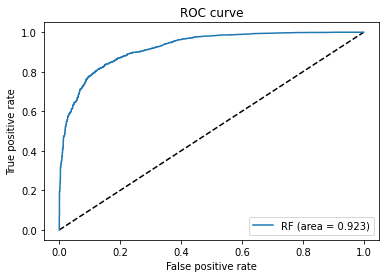

In [37]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**LOGISTIC REGRESSION**

In [38]:
from sklearn.linear_model import LogisticRegression
# Supervised transformation based on random forests

logr = LogisticRegression(random_state=0, max_iter=1000)
#rf = RandomForestClassifier(max_depth=3, n_estimators=10)
logr.fit(X_train, y_train)

y_pred_logr = logr.predict_proba(X_test)[:, 1]
fpr_logr, tpr_logr, thresholds_logr = roc_curve(y_test, y_pred_logr)
auc_logr = auc(fpr_logr, tpr_logr)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


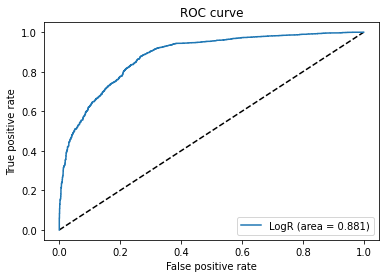

In [39]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='LogR (area = {:.3f})'.format(auc_logr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**KNN Classifier**

In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
auc_knn = auc(fpr_knn, tpr_knn)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


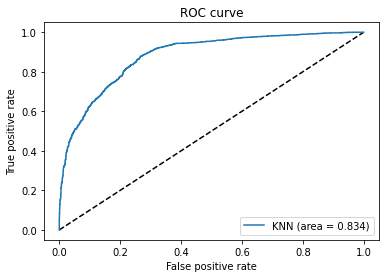

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='KNN (area = {:.3f})'.format(auc_knn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Decision Tree**

In [42]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict_proba(X_test)[:, 1]
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(y_test, y_pred_dtree)
auc_dtree = auc(fpr_dtree, tpr_dtree)

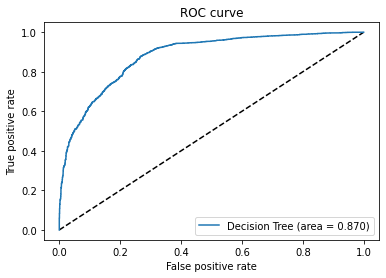

In [43]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='Decision Tree (area = {:.3f})'.format(auc_dtree))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()